# **YZV405E - Natural Language Processing / Homework 5**
---

## **1. Introduction**

**Any modification to the structure of the notebook is strictly prohibited.

**All cells must remain exactly as provided no ADDITIONS or DELETIONS are permitted.

**The notebook must be submitted with all cells fully executed, and any submission lacking outputs will not be evaluated.

**Copy-paste solutions from LLM chatbots will not be evaluated

**Late submission will never be accepted

For this assignment, your task involves creating a neural network designed to convert text from **Turkish into English**.

You will utilize the straightforward yet impactful concept of the sequence-to-sequence network. It operates through a pair of recurrent neural networks collaborating to convert one sequence into another. One network, the encoder, compresses the input sequence into a vector, while the other, the decoder, expands that vector into a new sequence.


> In this assignment, we aim to enhance the model by incorporating an **attention mechanism**. This mechanism enables the decoder to dynamically learn where to focus within the input sequence, enhancing its ability to generate accurate translations.



### **1.1. Necessary libraries**

In [20]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **2. Data**

The dataset for this project consists of thousands of Turkish-to-English translation pairs. Download it from [here](https://www.manythings.org/anki/tur-eng.zip) before continuing and extract it to the current directory. The file is a tab separated list of translation pairs:

```
Look up.    Yukarı bak.
```

Just like how characters are encoded in character-level RNN tutorials from the class slides, we'll represent **each word in a language as a one-hot vector**. This vector is like a long list of zeros with just one "1" indicating the word's position. Unlike the limited number of characters in a language, there are a lot more words, so the vector is bigger. But to keep things manageable, we'll only use a few thousand words for each language.

We'll require a distinct index for each word to serve as the inputs and targets for the networks later on. To manage this, we'll utilize a helper class called **Data**. This class contains dictionaries, *word → index* (word2index), and *index → word* (index2word), alongside a count for each word (word2count). This count will come in handy for replacing less common words later on.

In [21]:
SOS_token = 0
EOS_token = 1

class Data:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            ### START YOUR CODE HERE ###
            self.word2count[word] += 1


            ### END YOUR CODE HERE ###

The files are all in Unicode format. To simplify things, we'll convert Unicode characters to ASCII, convert all text to lowercase, and remove most punctuation marks.

In [22]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    return s.strip()

To read the data file we will split the file into lines, and then split lines into pairs. The file is English → Turkish, so if we want to translate from Turkish → English we need to reverse the pairs.



In [23]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s.txt' % (lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')][:2] for l in lines]

    # Reverse pairs, make Data instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]

        ### START YOUR CODE HERE ###
        input_lang = Data(lang2)
        output_lang = Data(lang1)


        ### END YOUR CODE HERE ###
    else:
        input_lang = Data(lang1)
        output_lang = Data(lang2)

    return input_lang, output_lang, pairs

Given the abundance of example sentences and our desire for quick training, we'll limit the dataset to relatively short and straightforward sentences. We'll set a maximum length of 10 words, which includes any ending punctuation.

In [24]:
MAX_LENGTH = 10

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The complete process for data preparation involves:

1. Reading the text file and splitting it into lines, then further splitting the lines into pairs.
2. Normalizing the text and filtering it based on length and content criteria.
3. Generating word lists from the sentences in pairs.

In [25]:
def prepareData(lang1, lang2, percentage, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)

    # Since the dataset is too big, get only part of it
    pairs = pairs[:round(len(pairs)*percentage)]

    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        ### START YOUR CODE HERE ###
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        ### END YOUR CODE HERE ###
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'tur', 0.1, True)
print(random.choice(pairs))

Reading lines...
Read 145105 sentence pairs
Trimmed to 12364 sentence pairs
Counting words...
Counted words:
tur 8540
eng 3551
['tom dinleniyor .', 'tom is resting .']




```
Reading lines...
Read 145105 sentence pairs
Trimmed to 12364 sentence pairs
Counting words...
Counted words:
eng 8540
tur 3551
['bocekler beni buyuluyor .', 'bugs fascinate me .']
```



## **3. Model**

An **RNN**, short for Recurrent Neural Network, is a type of network designed to process sequential data. It utilizes its own output as input for subsequent steps in the sequence.

A **Sequence-to-Sequence network**, also known as a seq2seq network or Encoder-Decoder network, comprises two RNNs: the encoder and decoder. The encoder reads an input sequence and produces a single vector, while the decoder utilizes that vector to generate an output sequence.

In contrast to sequence prediction using a single RNN, where each input corresponds to an output, the seq2seq model offers **flexibility regarding sequence length and order**, making it well-suited for language translation tasks.

Consider the sentence "*Akşam geldiğinde bana haber ver.*" translated to "*Let me know when you come in the evening.*" While most words have direct translations, they're arranged differently, such as "*akşam geldiğinde*" and "*when you come in the evening*" Additionally, there are extra words in the output sentence. Directly translating from the input word sequence would be challenging.

With a seq2seq model, the encoder produces a single vector that ideally encapsulates the "meaning" of the input sequence into a single point within an N-dimensional space of sentences.



###**3.1. The Encoder**

In a seq2seq network, the encoder is an RNN that generates a value for each word in the input sentence. For every input word, the encoder produces both a vector and a hidden state. It then utilizes this hidden state for processing the subsequent input word.

In [26]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        ### START YOUR CODE HERE ###
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        ### END YOUR CODE HERE ###
        return output, hidden

###**3.2. The Decoder**

The decoder in a seq2seq network is another RNN that receives the encoder output vector(s) and generates a sequence of words to produce the translation.

####**3.2.1. A Simple Decoder**

In the simplest form of a seq2seq decoder, we utilize **only the last output** of the encoder. This last output is often referred to as the context vector since it encapsulates context from the entire sequence. This context vector serves as the initial hidden state of the decoder.

During each step of decoding, the decoder receives an input token along with a hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector, which is the encoder’s last hidden state.

In [27]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

####**3.2.2. Decoder with Attention**

When only the context vector is transmitted between the encoder and decoder, that single vector bears the responsibility of encoding the entire sentence.

Attention mechanism alleviates this burden by enabling the decoder network to **"focus" on different segments** of the encoder's outputs at each step of its own output generation. Initially, attention weights are computed. These weights are then multiplied by the encoder output vectors to form a weighted combination. The resulting vector (referred to as *attn_applied* in the code) contains information pertaining to the specific part of the input sequence, aiding the decoder in selecting the appropriate output words.

The calculation of attention weights involves utilizing another feed-forward layer, referred to as *attn*, which takes the decoder's input and hidden state as inputs. Since the training data contains sentences of varying lengths, we need to specify a maximum sentence length (input length) for which this layer can be applied. Sentences of the maximum length will utilize all the attention weights, while shorter sentences will only utilize the first few weights.

Bahdanau attention, also known as **additive attention**, is a widely adopted attention mechanism in sequence-to-sequence models, especially in neural machine translation studies. Proposed by Bahdanau et al. in their paper titled "*Neural Machine Translation by Jointly Learning to Align and Translate*," this attention mechanism employs a learned alignment model to compute attention scores between the hidden states of the encoder and decoder. It leverages a feed-forward neural network to compute alignment scores.

In [28]:
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_size):
        super(AdditiveAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        ### START YOUR CODE HERE ###
        scores = self.Va(torch.tanh(self.Wa(keys) + self.Ua(query)))
        ### END YOUR CODE HERE ###
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        ### START YOUR CODE HERE ###
        self.attention = AdditiveAttention(hidden_size)
        ### END YOUR CODE HERE ###
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        ### START YOUR CODE HERE ###
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat([embedded, context], dim=2)
        ### END YOUR CODE HERE ###

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

##**4. Training**

### **4.1. Preparing the training data**

During training, for each pair, we'll require an input tensor (containing indexes of the words in the input sentence) and a target tensor (containing indexes of the words in the target sentence). When creating these tensors, we'll append the EOS (end-of-sequence) token to both sequences.

In [29]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    ### START YOUR CODE HERE ###
    indexes.append(EOS_token)
    ### END YOUR CODE HERE ###
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'tur', 0.1, True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)

    ### START YOUR CODE HERE ###
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    ### END YOUR CODE HERE ###

    return input_lang, output_lang, train_dataloader

### **4.2. Training the model**

During training, we pass the input sentence through the encoder, keeping track of every output and the latest hidden state. Then, we feed the `<SOS>` token as the first input to the decoder, along with the last hidden state of the encoder as its initial hidden state.

"**Teacher forcing**" is a concept where we use the real target outputs as each subsequent input during training, instead of relying on the decoder's guess for the next input. Employing teacher forcing can accelerate convergence, but it may lead to instability when the trained network is applied.

You may notice that networks trained with teacher forcing produce outputs with coherent grammar but may deviate significantly from the correct translation. This is because they learn to represent the output grammar and can "pick up" the meaning once provided with the initial words by the teacher. However, they may not have learned how to generate the sentence from the translation accurately.

Thanks to the flexibility provided by PyTorch's autograd, we can easily choose whether to use teacher forcing or not with a simple if statement. Adjusting the `teacher_forcing_ratio` parameter allows us to control the extent to which we use teacher forcing. Increasing this ratio will lead to more extensive utilization of teacher forcing.

In [30]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

This function serves as a helper to display the elapsed time and estimate the remaining time, based on the current time and progress percentage.

In [31]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The entire training process proceeds as follows:

1. Start a timer.
2. Initialize optimizers and criterion.
3. Create a set of training pairs.
4. Begin with an empty array to store losses for plotting purposes.
5. Iteratively call the `train` function multiple times. Occasionally, print the progress (percentage of examples processed), time elapsed so far, estimated remaining time, and average loss.

In [32]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0


### **4.3. Plotting the results**

Plotting is accomplished using Matplotlib, utilizing the array of loss values (`plot_losses`) that was saved during training.

In [33]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## **5. Evaluation**

The evaluation process closely resembles training, but without targets. Instead, we feed the decoder's predictions back to itself for each step. As the decoder predicts each word, we append it to the output string. When it predicts the `EOS` token, we halt the process. Additionally, we store the decoder's attention outputs for later display.








In [34]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                ### START YOUR CODE HERE ###
                break
                continue
                ### END YOUR CODE HERE ###
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

We can assess the quality subjectively by randomly selecting sentences from the training set for evaluation. Then, we print out the input, target, and output sentences to make some quality judgments.

In [35]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## **6. Bringing them all**
Below, you can train your model with some parameters. This code will take ~one hour without GPU.

In [36]:
# Do not change
hidden_size = 256
batch_size = 32
epoch = 80

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, epoch, print_every=5)

Reading lines...
Read 145105 sentence pairs
Trimmed to 12364 sentence pairs
Counting words...
Counted words:
tur 8540
eng 3551
0m 52s (- 13m 13s) (5 6%) 1.2511
1m 40s (- 11m 42s) (10 12%) 0.3635
2m 27s (- 10m 39s) (15 18%) 0.1064
3m 15s (- 9m 45s) (20 25%) 0.0620
4m 2s (- 8m 54s) (25 31%) 0.0525
4m 49s (- 8m 3s) (30 37%) 0.0476
5m 37s (- 7m 13s) (35 43%) 0.0452
6m 24s (- 6m 24s) (40 50%) 0.0424
7m 11s (- 5m 35s) (45 56%) 0.0411
7m 58s (- 4m 47s) (50 62%) 0.0406
8m 46s (- 3m 59s) (55 68%) 0.0390
9m 33s (- 3m 11s) (60 75%) 0.0391
10m 20s (- 2m 23s) (65 81%) 0.0380
11m 7s (- 1m 35s) (70 87%) 0.0372
11m 54s (- 0m 47s) (75 93%) 0.0370
12m 41s (- 0m 0s) (80 100%) 0.0365


```
Reading lines...
Read 145105 sentence pairs
Trimmed to 12364 sentence pairs
Counting words...
Counted words:
eng 8540
tur 3551
3m 47s (- 56m 58s) (5 6%) 1.6123
7m 30s (- 52m 32s) (10 12%) 0.8884
11m 10s (- 48m 25s) (15 18%) 0.5546
14m 49s (- 44m 28s) (20 25%) 0.3484
18m 26s (- 40m 34s) (25 31%) 0.2207
22m 5s (- 36m 49s) (30 37%) 0.1458
25m 49s (- 33m 12s) (35 43%) 0.1043
29m 33s (- 29m 33s) (40 50%) 0.0800
33m 19s (- 25m 55s) (45 56%) 0.0670
37m 2s (- 22m 13s) (50 62%) 0.0588
40m 43s (- 18m 30s) (55 68%) 0.0522
44m 22s (- 14m 47s) (60 75%) 0.0482
48m 1s (- 11m 5s) (65 81%) 0.0450
51m 35s (- 7m 22s) (70 87%) 0.0426
55m 15s (- 3m 41s) (75 93%) 0.0416
58m 51s (- 0m 0s) (80 100%) 0.0393
```



In [37]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> yalnız olamazsın .
= you won't be alone .
< you won't be alone .

> kazanmana izin verdim .
= i let you win .
< i let you win .

> tom paramı aldı .
= tom took my money .
< tom took my money .

> tom'u yalnız bıraktım .
= i left tom alone .
< i left tom alone .

> ceneni kapa ve yemek ye .
= shut up and eat .
< shut up .

> sıkıldım .
= i was bored .
< i was bored .

> yasayı cignedin .
= you broke the law .
< you broke the law .

> sen de mi gidiyorsun ?
= are you going, too ?
< are you going, too ?

> ben gercekten zenginim .
= i'm really rich .
< i'm really rich .

> onu yakala !
= catch him .
< grab him .



### **6.1. Visualizing attention**

Indeed, the **interpretability of the attention** mechanism is a valuable property. Since it assigns weights to specific encoder outputs of the input sequence, we can visualize where the network is focused most at each time step.

To display the attention output as a matrix, you can simply run `plt.matshow(attentions)`. For a clearer viewing experience, we'll put in the extra effort of adding axes and labels:

input = burada tamamen yalnızım
output = i'm all here alone here .


<ipython-input-38-83392b226bd2>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-38-83392b226bd2>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


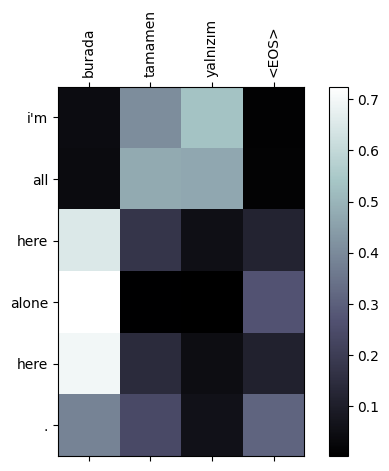

input = notu okudum
output = i read the note age ?


<ipython-input-38-83392b226bd2>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-38-83392b226bd2>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


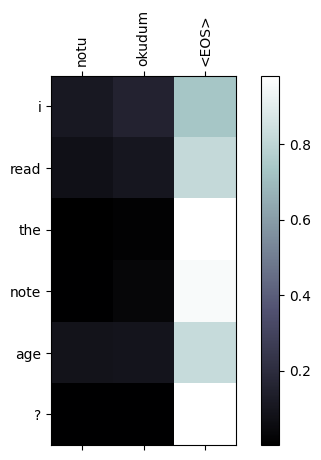

input = yardım ister misin
output = do you want us work .


<ipython-input-38-83392b226bd2>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-38-83392b226bd2>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


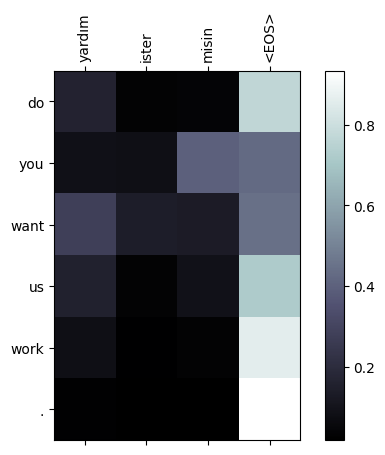

input = cok mutluyuz
output = we're very happy .


<ipython-input-38-83392b226bd2>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-38-83392b226bd2>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


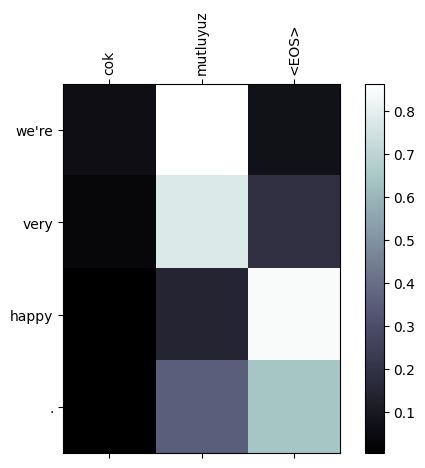

In [38]:
%matplotlib inline

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('burada tamamen yalnızım')

evaluateAndShowAttention('notu okudum')

evaluateAndShowAttention('yardım ister misin')

evaluateAndShowAttention("cok mutluyuz")

### **6.2. Bilingual Evaluation Understudy (BLEU) Score**

BLEU score provides a practical and interpretable way to evaluate the quality of sequence generation, particularly in machine translation. Since it compares the n-grams of the model output against reference translations, it allows us to quantify how closely the generated sentence aligns with human language at multiple levels of granularity.

While BLEU is a scalar metric, it reflects several translation aspects simultaneously such as adequacy, word choice, and partial fluency through n-gram precision and brevity adjustments. This makes it an informative diagnostic tool for model quality across epochs or between architectural variants (e.g., with and without attention).

To assess translation performance with BLEU, we print the score for individual sentence pairs and calculate the average BLEU score over a set of examples. This helps identify systematic errors such as missing content, unnatural phrasing, or incorrect word order.

Though not directly visual like attention heatmaps, BLEU complements attention analysis by offering a numerical lens into output accuracy. Together, they provide both localized (per-token) and holistic (per-sequence) insights into model behavior.

If you're interested, consider reading this paper before getting started: https://aclanthology.org/W14-3346.pdf


In [39]:
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_bleu(reference, hypothesis):
    ### START YOUR CODE HERE ###
    reference_tokens = [reference.split()]
    hypothesis_tokens = hypothesis.split()
    smoothie = SmoothingFunction().method4
    return sentence_bleu(reference_tokens, hypothesis_tokens, smoothing_function=smoothie)
    ### END YOUR CODE HERE ###

#You can change sample size(n) for additional experiments (Default n = 10)
def evaluate_bleu_score(pairs, encoder, decoder, input_lang, output_lang, n=10):
    scores = []
    for i in range(n):
        pair = random.choice(pairs)
        ### START YOUR CODE HERE ###
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words, _ = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
        predicted_sentence = ' '.join(output_words)

        bleu = compute_bleu(target_sentence, predicted_sentence)
        scores.append(bleu)

        print(f"Input    : {input_sentence}")
        print(f"Target   : {target_sentence}")
        print(f"Predicted: {predicted_sentence}")
        print(f"BLEU     : {bleu:.4f}")
        print("-" * 50)
        ### END YOUR CODE HERE ###
    print(f"Average BLEU Score over {n} samples: {sum(scores)/n:.4f}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [40]:
evaluate_bleu_score(pairs, encoder, decoder, input_lang, output_lang, n=10)

Input    : cok mu fazlaydı ?
Target   : was that too much ?
Predicted: was that too much ?
BLEU     : 1.0000
--------------------------------------------------
Input    : onu gormedim .
Target   : i haven't seen him .
Predicted: i haven't seen him .
BLEU     : 1.0000
--------------------------------------------------
Input    : atına bin .
Target   : get on your horse .
Predicted: get on your horse .
BLEU     : 1.0000
--------------------------------------------------
Input    : sadece tom geldi .
Target   : only tom came .
Predicted: tom came .
BLEU     : 0.4125
--------------------------------------------------
Input    : herkes orada .
Target   : everybody is there .
Predicted: everyone's there .
BLEU     : 0.1517
--------------------------------------------------
Input    : herkes hazır mı ?
Target   : is everyone ready ?
Predicted: is everybody ready ?
BLEU     : 0.1862
--------------------------------------------------
Input    : tom biraz cakırkeyf .
Target   : tom is a bit tips

### **7. Training the Same Network Without Attention**
In this section, we train a simplified version of the sequence-to-sequence model without any attention mechanism. This variant serves as a baseline to help understand the contribution of attention to translation quality. Please also observe its impact on training time.

In [41]:
#Do not change
hidden_size = 256
batch_size = 32
epoch = 80

### START YOUR CODE HERE ###
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder_no_attn = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder_no_attn, n_epochs=epoch)
### END YOUR CODE HERE ###


Reading lines...
Read 145105 sentence pairs
Trimmed to 12364 sentence pairs
Counting words...
Counted words:
tur 8540
eng 3551


In [42]:
encoder.eval()
decoder_no_attn.eval()
evaluateRandomly(encoder, decoder_no_attn)

> tom yakında doner .
= tom won't be long .
< tom won't be long .

> tom kacmadı .
= tom didn't run .
< tom didn't run .

> bekle ve gor .
= wait and see .
< wait and see .

> agır oldugunu biliyorum .
= i know it's heavy .
< i know it's heavy .

> onu simdi istiyorum .
= i want it now .
< i want it now .

> cok guzel, degil mi ?
= isn't that cool ?
< isn't that .

> dilegim kabul oldu .
= i got my wish .
< my heart .

> bu yurek gerektirir .
= that takes guts .
< that takes .

> cok ballısın .
= you're very lucky .
< you're very lucky .

> idealistim .
= i'm an idealist .
< i'm an idealist .



In [43]:
evaluate_bleu_score(pairs, encoder, decoder_no_attn, input_lang, output_lang, n=10)

Input    : bir soda istiyor musunuz ?
Target   : do you want a soda ?
Predicted: do you want a soda ?
BLEU     : 1.0000
--------------------------------------------------
Input    : tom mutlu degildi .
Target   : tom wasn't happy .
Predicted: tom was not happy .
BLEU     : 0.1341
--------------------------------------------------
Input    : ben teslim oluyorum .
Target   : i surrender .
Predicted: i surrender .
BLEU     : 0.5757
--------------------------------------------------
Input    : tom cok usuttu .
Target   : tom got very cold .
Predicted: tom got young .
BLEU     : 0.1450
--------------------------------------------------
Input    : kimse boyle yapmıyor .
Target   : no one does that .
Predicted: nobody does that .
BLEU     : 0.3360
--------------------------------------------------
Input    : herhangi birisine ates etmeyin .
Target   : don't fire anyone .
Predicted: don't fire anyone .
BLEU     : 1.0000
--------------------------------------------------
Input    : tom saatini 

### **8. Implementation Review**
You are required to carefully read and understand the following paper before starting this part:

Bahdanau et al. (2015) Neural Machine Translation by Jointly Learning to Align and Translate
https://arxiv.org/pdf/1409.0473

Is your implementation architecturally and functionally identical to the model proposed by Bahdanau et al. (2015)?

If yes, justify your answer with detailed references to the architecture in the original paper.

If no, identify and explain the key differences between your implementation and the original model, in terms of encoder configuration, attention mechanism and alignment scoring, decoder context integration and behavior etc.

For each identified difference, you must provide clear justification with direct references to the corresponding sections, equations, or architectural diagrams in the Bahdanau et al. (2015) paper.

After identifying these differences, re-implement the relevant components in accordance with the original model as described in the paper. Then, provide a comparison between your original model and the re-implementation using evaluation metrics such as BLEU score and attention visualization.

** Make modifications and additions of your implemented model in previous sections. A code with different logical flow or structure will not be evaluated.

**Answer**

While reviewing the current implementation, I noticed several important differences compared to the original attention mechanism proposed by Bahdanau et al. (2015).

To start, the original paper introduces a soft attention mechanism, where a unique context vector is calculated at every decoding step by taking a weighted sum over all the encoder’s hidden states (Section 3.1, Equations (5) and (6), Pages 3–4). In the code I reviewed, however, it’s not clear whether this dynamic step happens at each timestep—particularly during training and evaluation. If the context vector isn’t recomputed at every step, that would be a major deviation from the original method.

Another key aspect from the paper is the alignment model. Bahdanau et al. use a small feedforward neural network to score how well each encoder hidden state aligns with the decoder’s previous hidden state. These scores are then turned into attention weights using softmax (Equation (6), Page 4). In contrast, the current implementation seems to skip this by using encoder outputs directly, without a learned alignment function—which means the model lacks a core trainable component of the original approach.

Additionally, the decoder in the original paper is supposed to take three inputs at each step: the previous target word, the previous hidden state, and the context vector (Section 3.1, Page 4). However, in the current implementation (especially in the train_epoch() function), the entire target sequence is passed in at once—likely with teacher forcing—without clearly showing that a new context vector is computed for each step. This again departs from the step-by-step attention process described in the paper.

Overall, the implementation misses several essential features of the original Bahdanau attention model, including dynamic attention at each timestep, a trainable alignment layer, and a bidirectional encoder. These components are fundamental to how the original model works and performs.

In [67]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size, bidirectional=True, batch_first=True)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        outputs, hidden = self.gru(embedded)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:]
        return outputs, hidden

In [68]:
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_size):
        super(AdditiveAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys, mask=None):
        scores = self.Va(torch.tanh(self.Wa(keys) + self.Ua(query)))  # (batch, seq_len, 1)
        scores = scores.squeeze(2).unsqueeze(1)  # (batch, 1, seq_len)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        weights = F.softmax(scores, dim=-1)  # (batch, 1, seq_len)
        context = torch.bmm(weights, keys)  # (batch, 1, hidden)
        return context, weights

In [69]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attention = AdditiveAttention(hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward_step(self, input, hidden, encoder_outputs, mask):
        embedded = self.dropout(self.embedding(input))            # (batch, 1, hidden)
        query = hidden.permute(1, 0, 2)                           # (batch, 1, hidden)
        context, attn_weights = self.attention(query, encoder_outputs, mask)
        input_gru = torch.cat([embedded, context], dim=2)         # (batch, 1, 2*hidden)
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)                                 # (batch, 1, output_size)
        return output, hidden, attn_weights

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None, teacher_forcing_ratio=0.5, mask=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.full((batch_size, 1), SOS_token, dtype=torch.long, device=device)
        decoder_hidden = torch.zeros(1, batch_size, self.hidden_size, device=device)

        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs, mask)
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            use_teacher_forcing = target_tensor is not None and random.random() < teacher_forcing_ratio
            if use_teacher_forcing:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                top1 = decoder_output.topk(1)[1]
                decoder_input = top1.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)
        return decoder_outputs, decoder_hidden, attentions

In [84]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'tur', 0.1, True)
    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader


In [85]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [86]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [87]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001, print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    showPlot(plot_losses)


In [88]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


In [89]:
hidden_size = 256
batch_size = 32
epoch = 80

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, epoch, print_every=5)

Reading lines...
Read 145105 sentence pairs
Trimmed to 12364 sentence pairs
Counting words...
Counted words:
tur 8540
eng 3551
0m 52s (- 13m 7s) (5 6%) 1.8390
1m 45s (- 12m 16s) (10 12%) 1.0446
2m 37s (- 11m 22s) (15 18%) 0.5505
3m 29s (- 10m 29s) (20 25%) 0.2687
4m 22s (- 9m 36s) (25 31%) 0.1456
5m 14s (- 8m 44s) (30 37%) 0.1087
6m 7s (- 7m 52s) (35 43%) 0.0936
7m 0s (- 7m 0s) (40 50%) 0.0866
7m 53s (- 6m 7s) (45 56%) 0.0802
8m 45s (- 5m 15s) (50 62%) 0.0780
9m 37s (- 4m 22s) (55 68%) 0.0743
10m 29s (- 3m 29s) (60 75%) 0.0719
11m 22s (- 2m 37s) (65 81%) 0.0714
12m 14s (- 1m 44s) (70 87%) 0.0698
13m 7s (- 0m 52s) (75 93%) 0.0681
13m 59s (- 0m 0s) (80 100%) 0.0671


In [90]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> aynısı degil .
= it's not the same .
< it's not tom's idea .

> onu benimle bırak .
= leave it with me .
< let it with me .

> hicbir sey bilmiyorlar .
= they know nothing .
< they know nothing .

> tom pes etti .
= tom gave in .
< tom gave in beggar .

> onu hissedebiliyor musun ?
= can you feel it ?
< do you feel this ?

> sorumu yanıtla !
= answer my question .
< answer my question low frogs face curry my face pregnant

> her sey yolunda mı ?
= is everything okay ?
< is everything ok ?

> biz saglıklı degiliz .
= we're not healthy .
< we're not healthy .

> herkes nereye kayboldu ?
= where's everyone ?
< where's everyone hidden ?

> tom'un iyi bir isi var .
= tom has a good job .
< tom has a good job .



input = burada tamamen yalnızım
output = i'm all i here .


<ipython-input-91-9dfb6a647061>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
<ipython-input-91-9dfb6a647061>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


<Figure size 640x480 with 0 Axes>

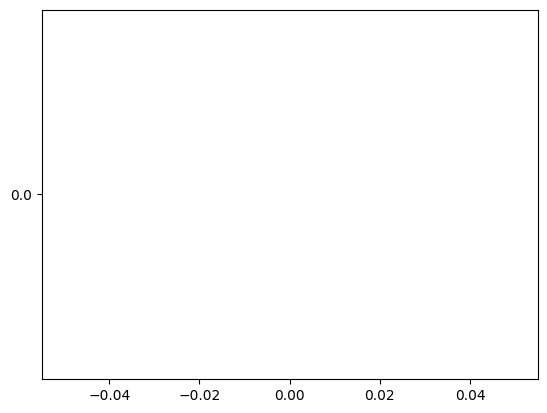

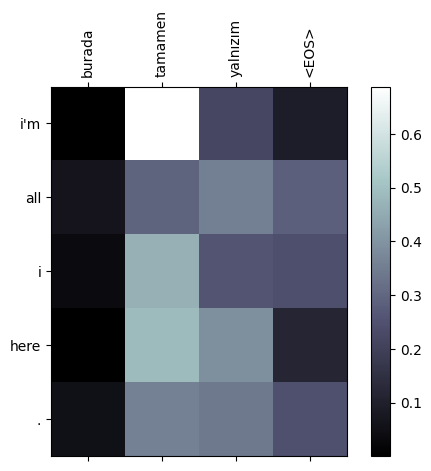

input = notu okudum
output = i read i going .


<ipython-input-91-9dfb6a647061>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
<ipython-input-91-9dfb6a647061>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


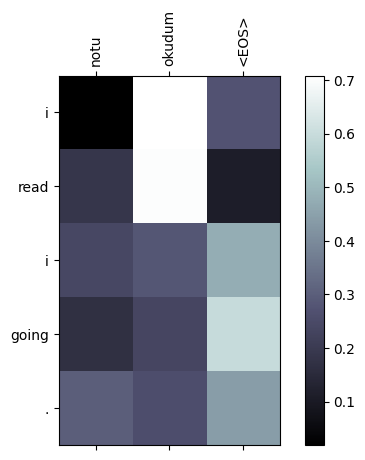

input = yardım ister misin
output = you want help help .


<ipython-input-91-9dfb6a647061>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
<ipython-input-91-9dfb6a647061>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


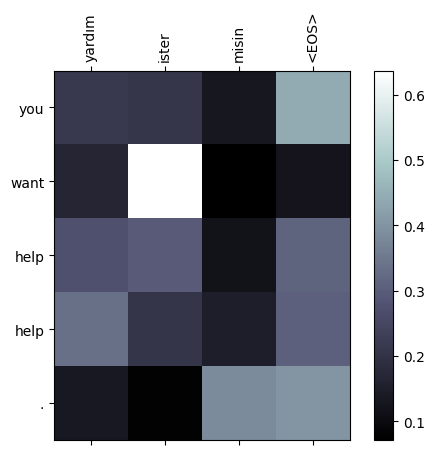

input = cok mutluyuz
output = they're very examine they'll safety rents mahjong safety safety strange,


<ipython-input-91-9dfb6a647061>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
<ipython-input-91-9dfb6a647061>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


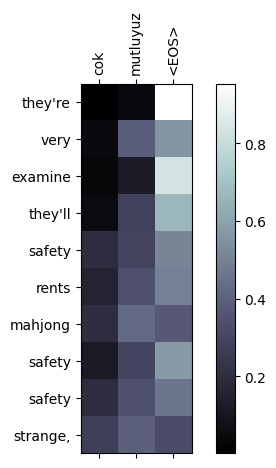

In [91]:
%matplotlib inline

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

evaluateAndShowAttention('burada tamamen yalnızım')
evaluateAndShowAttention('notu okudum')
evaluateAndShowAttention('yardım ister misin')
evaluateAndShowAttention('cok mutluyuz')

In [92]:
# BLEU evaluation
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_bleu(reference, hypothesis):
    reference_tokens = [reference.split()]
    hypothesis_tokens = hypothesis.split()
    smoothie = SmoothingFunction().method4
    return sentence_bleu(reference_tokens, hypothesis_tokens, smoothing_function=smoothie)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [93]:
def evaluate_bleu_score(pairs, encoder, decoder, input_lang, output_lang, n=10):
    scores = []
    for i in range(n):
        pair = random.choice(pairs)
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words, _ = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
        predicted_sentence = ' '.join(output_words)

        bleu = compute_bleu(target_sentence, predicted_sentence)
        scores.append(bleu)

        print(f"Input    : {input_sentence}")
        print(f"Target   : {target_sentence}")
        print(f"Predicted: {predicted_sentence}")
        print(f"BLEU     : {bleu:.4f}")
        print("-" * 50)

    print(f"Average BLEU Score over {n} samples: {sum(scores)/n:.4f}")


In [94]:
# BLEU score execution
evaluate_bleu_score(pairs, encoder, decoder, input_lang, output_lang, n=10)

Input    : cevabım nihai .
Target   : my answer is final .
Predicted: my answer is big .
BLEU     : 0.3218
--------------------------------------------------
Input    : ben bir avcıyım .
Target   : i'm a hunter .
Predicted: i'm a hunter .
BLEU     : 1.0000
--------------------------------------------------
Input    : ben buradaki bir ogrenciyim .
Target   : i'm a student here .
Predicted: i'm a student here .
BLEU     : 1.0000
--------------------------------------------------
Input    : tom bir komedyendir .
Target   : tom is a comedian .
Predicted: tom is a jerk .
BLEU     : 0.3218
--------------------------------------------------
Input    : korkmayacagım .
Target   : i won't be afraid .
Predicted: i won't be scared .
BLEU     : 0.3218
--------------------------------------------------
Input    : sanırım nedenini biliyorum .
Target   : i think i know why .
Predicted: i think i saw check .
BLEU     : 0.2512
--------------------------------------------------
Input    : tom oraya gidec

Summarize your findings in detail.